## LLM

In [1]:
import torch as torch
import numpy as np
import pickle as pkl
from tqdm.notebook import tqdm
from src.transformer_alt import Transformer
from src.optimization import train_step, forward_and_loss, group_decay_parameters, save_checkpoint, load_checkpoint
from src.utils import saver, loader
from torch.utils.data import TensorDataset, DataLoader
from IPython.display import clear_output
import matplotlib.pyplot as plt

print("PyTorch version:", torch.__version__)  
print("CUDA toolkit version PyTorch was built with:", torch.version.cuda)  
print("cuDNN version:", torch.backends.cudnn.version()) 
print("cuda available:", torch.cuda.is_available())

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_float32_matmul_precision('high')

PyTorch version: 2.7.1+cu128
CUDA toolkit version PyTorch was built with: 12.8
cuDNN version: 90701
cuda available: True


## Load Data

In [2]:
tokenizer = loader("tokenizers/cnn_tokenizer.pkl")

In [3]:
corpus_train1 = torch.tensor(loader("corpus/cnn_dailymail_article_train_tokens1.pkl"))
corpus_train2 = torch.tensor(loader("corpus/cnn_dailymail_article_train_tokens2.pkl"))
corpus_train3 = torch.tensor(loader("corpus/cnn_dailymail_article_train_tokens3.pkl"))
corpus_train4 = torch.tensor(loader("corpus/cnn_dailymail_article_train_tokens4.pkl"))
corpus_train = torch.cat((corpus_train1, corpus_train2, corpus_train3, corpus_train4), dim=0)

corpus_test = torch.tensor(loader("corpus/cnn_dailymail_article_test_tokens.pkl"))

In [4]:
def batch_data(corpus, batch_length=1024, offset=None):
    """
    Splits the corpus into batches of size batch_size.
    """
    length = len(corpus)
    batches = length // batch_length
    corpus_truncated = corpus[:batches * batch_length]  # trim to a multiple of batch_length
    corpus_batched = corpus_truncated.view(-1, batch_length)  # reshape into batches

    # overlapping batches augmentation
    if offset is not None:
        corpus_offset = corpus_truncated[offset : offset - batch_length]
        corpus_offset = corpus_offset.view(-1, batch_length)  # reshape into batches
        corpus_batched = torch.cat((corpus_batched, corpus_offset), dim=0)  # concatenate the offset batches

    return corpus_batched

In [5]:
corpus_train_batched = batch_data(corpus_train, batch_length=1024, offset=None)
corpus_test_batched = batch_data(corpus_test, batch_length=1024, offset=None)

In [6]:
loader_train = DataLoader(
    corpus_train_batched,
    batch_size=6,
    shuffle=True,       # shuffle every epoch
    drop_last=True      # drop the last incomplete batch
)

loader_test = DataLoader(
    corpus_test_batched,
    batch_size=6,
    shuffle=True,      # no need to shuffle test data
    drop_last=True      # drop the last incomplete batch
)

## Initialize Model

In [7]:
torch.manual_seed(42)

embed_dim = 44*12
ff_dim = 4*embed_dim
heads = 12
tf_blocks = 12

model = Transformer(
    embed_dim=embed_dim,
    embed_dim_ratio=1.1,
    ff_dim=ff_dim,
    heads=heads,
    tf_blocks=tf_blocks,
    vocab_size=tokenizer.vocab_size,
    max_seq_len=1024,
    dropout=0.1,
    start_token_id=tokenizer.token_to_idx["<s>"],
    use_weight_tying=False
).to(device)

optimizer_grouped_parameters = group_decay_parameters(
    model,
    weight_decay=0.1,
    no_decay=["bias", "LayerNorm.weight"],
    )

loss_train_list = []
loss_eval_list = []

filename = "checkpoint_transformer_alt.pth"

In [8]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

print("Number of parameters:", get_n_params(model))

Number of parameters: 197263430


In [9]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=5e-5)
scaler = torch.amp.GradScaler("cuda")

num_epochs      = 2
steps_per_epoch = len(loader_train)
warmup_steps    = 250

def lr_lambda(step):
    if step < warmup_steps:
        return float(step) / float(max(1, warmup_steps))
    return 1.0

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

### Load Model

In [10]:
#model, optimizer, scheduler = load_checkpoint("checkpoint_transformer_alt.pth", model, optimizer, scheduler)
#loss_train_list = loader("loss_train_alt.pkl")
#loss_eval_list = loader("loss_eval_alt.pkl")

In [11]:
optimizer.zero_grad()
model.train()
device = next(model.parameters()).device
accum_steps = 10

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    for step, batch in enumerate(tqdm(loader_train, desc="Training")):
        batch = batch.to(device)
        loss_train = train_step(model, 
                          batch, 
                          criterion, 
                          optimizer, 
                          scaler, 
                          scheduler, 
                          accum_steps,
                          step).item()
        if (step+1) % 500 == 0:
            model.eval()
            lr = scheduler.get_last_lr()[0]
            iter_test = iter(loader_test)
            with torch.no_grad():
                loss_eval = np.mean([forward_and_loss(model, next(iter_test).to(device), criterion).item() for _ in range(accum_steps)])
                print(f"Step {step+1}, Loss: {loss_train:<.4f}, Loss_eval: {loss_eval:<.4f}, Learning Rate: {lr:4e}")

            loss_train_list.append(loss_train)
            loss_eval_list.append(loss_eval)

            model.train()

        if (step+1) % 5000 == 0:
            save_checkpoint(model, 
                            optimizer, 
                            scheduler, 
                            filename=filename)
            saver("loss_train.pkl", loss_train_list)
            saver("loss_eval.pkl", loss_eval_list)
            
    save_checkpoint(model, 
                    optimizer, 
                    scheduler, 
                    filename=filename)
    saver("loss_train.pkl", loss_train_list)
    saver("loss_eval.pkl", loss_eval_list)


Epoch 1/2


Training:   0%|          | 0/43829 [00:00<?, ?it/s]

KeyboardInterrupt: 

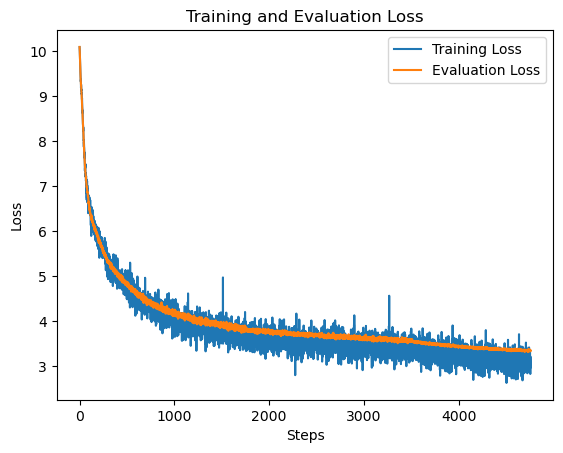

In [ ]:
plt.plot(loss_train_list)
plt.plot(loss_eval_list)
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training and Evaluation Loss")
plt.legend(["Training Loss", "Evaluation Loss"])
plt.show()


In [ ]:
import textwrap
import ipywidgets as widgets
from IPython.display import display
from torch.distributions import Categorical

class Inference:
    def __init__(self, model, tokenizer, context_length, device):
        self.model = model
        self.tokenizer = tokenizer
        self.context_length = context_length
        self.device = device
        

    def run(self, text, T, k, mode=None):
        if mode == "summary":
            text = "<s><b>" + text + "<h>"
        elif mode == "expand":
            text = "<s><h>" + text + "<b>"
        else:
            pass

        tokens = torch.tensor(self.tokenizer.encode(text.lower()), dtype=torch.long).reshape(1, -1).to(self.device)

        self.display = Display()

        model.eval()
        with torch.no_grad():
            for i in range(self.context_length):
                next = self.next_token(tokens, T, k,)

                tokens = torch.cat([tokens, next.reshape(1,1)], dim=1)
                text = tokenizer.decode(tokens[0].tolist())
                self.display.update(text)

                if next[0] == tokenizer.token_to_idx["</s>"]:
                    break
                

    def next_token(self, tokens, T, k):
        logits = self.model(tokens)[0, -1:]
        topk_vals, _    = torch.topk(logits, k=k)
        kth_value       = topk_vals[:,-1]

        logits = torch.where(logits >= kth_value, logits, -torch.inf)
        dist = Categorical(logits=logits/T)
        next = dist.sample()

        return next


class Display:
    def __init__(self):
        self.wrapper = textwrap.TextWrapper(width=80)

        self.ta = widgets.Textarea(
            value="",
            layout=widgets.Layout(width='80ch', height='20em'),
            disabled=True
        )
        display(self.ta)

    def update(self, text):
        self.ta.value = self.wrapper.fill(text.replace("\n", " "))  # this updates in-place


In [ ]:
inference = Inference(model, tokenizer, context_length=1024, device=device)

In [ ]:
text = "<s><h>A magical horse was spotted in England. It was found in a field. The magical horse is able to breath fire. Scientists don't know where it came from.<b>"

T = 1
k = 50
inference.run(text, T, k)

Textarea(value='', disabled=True, layout=Layout(height='20em', width='80ch'))

RuntimeError: The size of tensor a (1025) must match the size of tensor b (1024) at non-singleton dimension 3